In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Gathering Data Using Yfinance Package

In [26]:
stockTicker = "aapl"
aapl= yf.Ticker(stockTicker)

In [27]:
aapl.info.keys()

dict_keys(['address1', 'city', 'state', 'zip', 'country', 'phone', 'website', 'industry', 'industryKey', 'industryDisp', 'sector', 'sectorKey', 'sectorDisp', 'longBusinessSummary', 'fullTimeEmployees', 'companyOfficers', 'auditRisk', 'boardRisk', 'compensationRisk', 'shareHolderRightsRisk', 'overallRisk', 'governanceEpochDate', 'compensationAsOfEpochDate', 'maxAge', 'priceHint', 'previousClose', 'open', 'dayLow', 'dayHigh', 'regularMarketPreviousClose', 'regularMarketOpen', 'regularMarketDayLow', 'regularMarketDayHigh', 'dividendRate', 'dividendYield', 'exDividendDate', 'payoutRatio', 'fiveYearAvgDividendYield', 'beta', 'trailingPE', 'forwardPE', 'volume', 'regularMarketVolume', 'averageVolume', 'averageVolume10days', 'averageDailyVolume10Day', 'bidSize', 'askSize', 'marketCap', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh', 'priceToSalesTrailing12Months', 'fiftyDayAverage', 'twoHundredDayAverage', 'trailingAnnualDividendRate', 'trailingAnnualDividendYield', 'currency', 'enterpriseValue', 'pro

In [28]:
df = aapl.history(start="2016-01-01",end="2024-01-01")
df.reset_index(inplace=True)

In [29]:
df.rename(columns= {"Date" : "date","Open" : "open" , "High" : "high" , "Low":"low","Close":"close","Adj Close":"adj_close","Volume":"volume"},inplace= True)
df.drop(['Dividends','Stock Splits'],inplace=True,axis=1)
df['date'] = df['date'].dt.tz_localize(None)
df.sample(5)
df.set_index('date',inplace=True)

#### Check for missing values

In [30]:
null_values = df.isnull().sum()
NaN_values = df.isna().sum()
zero_values = 0 in df

print( 'Null values in Stock Data = ','\n', null_values)
print( 'NaN values in Stock Data = ','\n', NaN_values)
print( 'Zeroes in Stock Data = ', zero_values)

Null values in Stock Data =  
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
NaN values in Stock Data =  
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
Zeroes in Stock Data =  False


#### Gathering Data about whether the timeseries is additive or multiplicative

In [31]:
df

open        high         low       close     volume
date                                                                 
2016-01-04   23.353857   23.982029   23.215022   23.977476  270597600
2016-01-05   24.068514   24.091274   23.308337   23.376616  223164000
2016-01-06   22.887278   23.299232   22.730237   22.919142  273829600
2016-01-07   22.459392   22.789409   21.947296   21.951847  324377600
2016-01-08   22.429812   22.557267   22.022411   22.067930  283192000
...                ...         ...         ...         ...        ...
2023-12-22  195.179993  195.410004  192.970001  193.600006   37122800
2023-12-26  193.610001  193.889999  192.830002  193.050003   28919300
2023-12-27  192.490005  193.500000  191.089996  193.149994   48087700
2023-12-28  194.139999  194.660004  193.169998  193.580002   34049900
2023-12-29  193.899994  194.399994  191.729996  192.529999   42628800

[2012 rows x 5 columns]

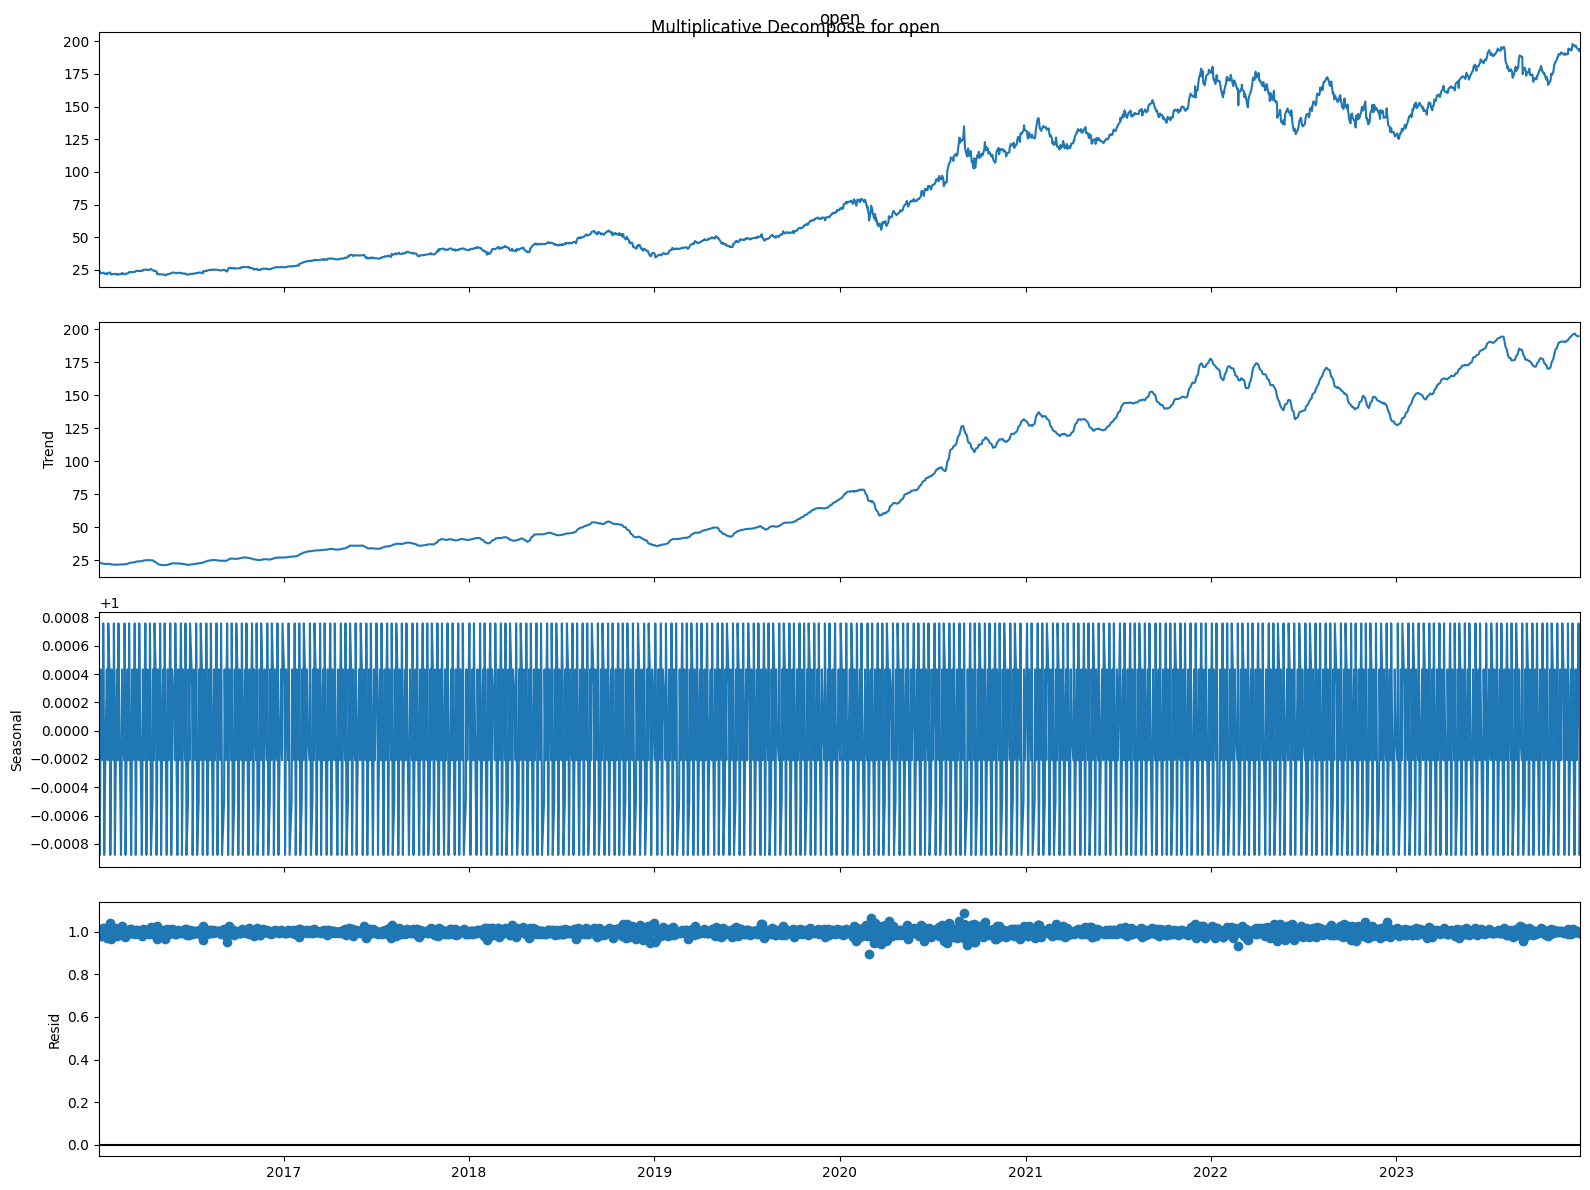

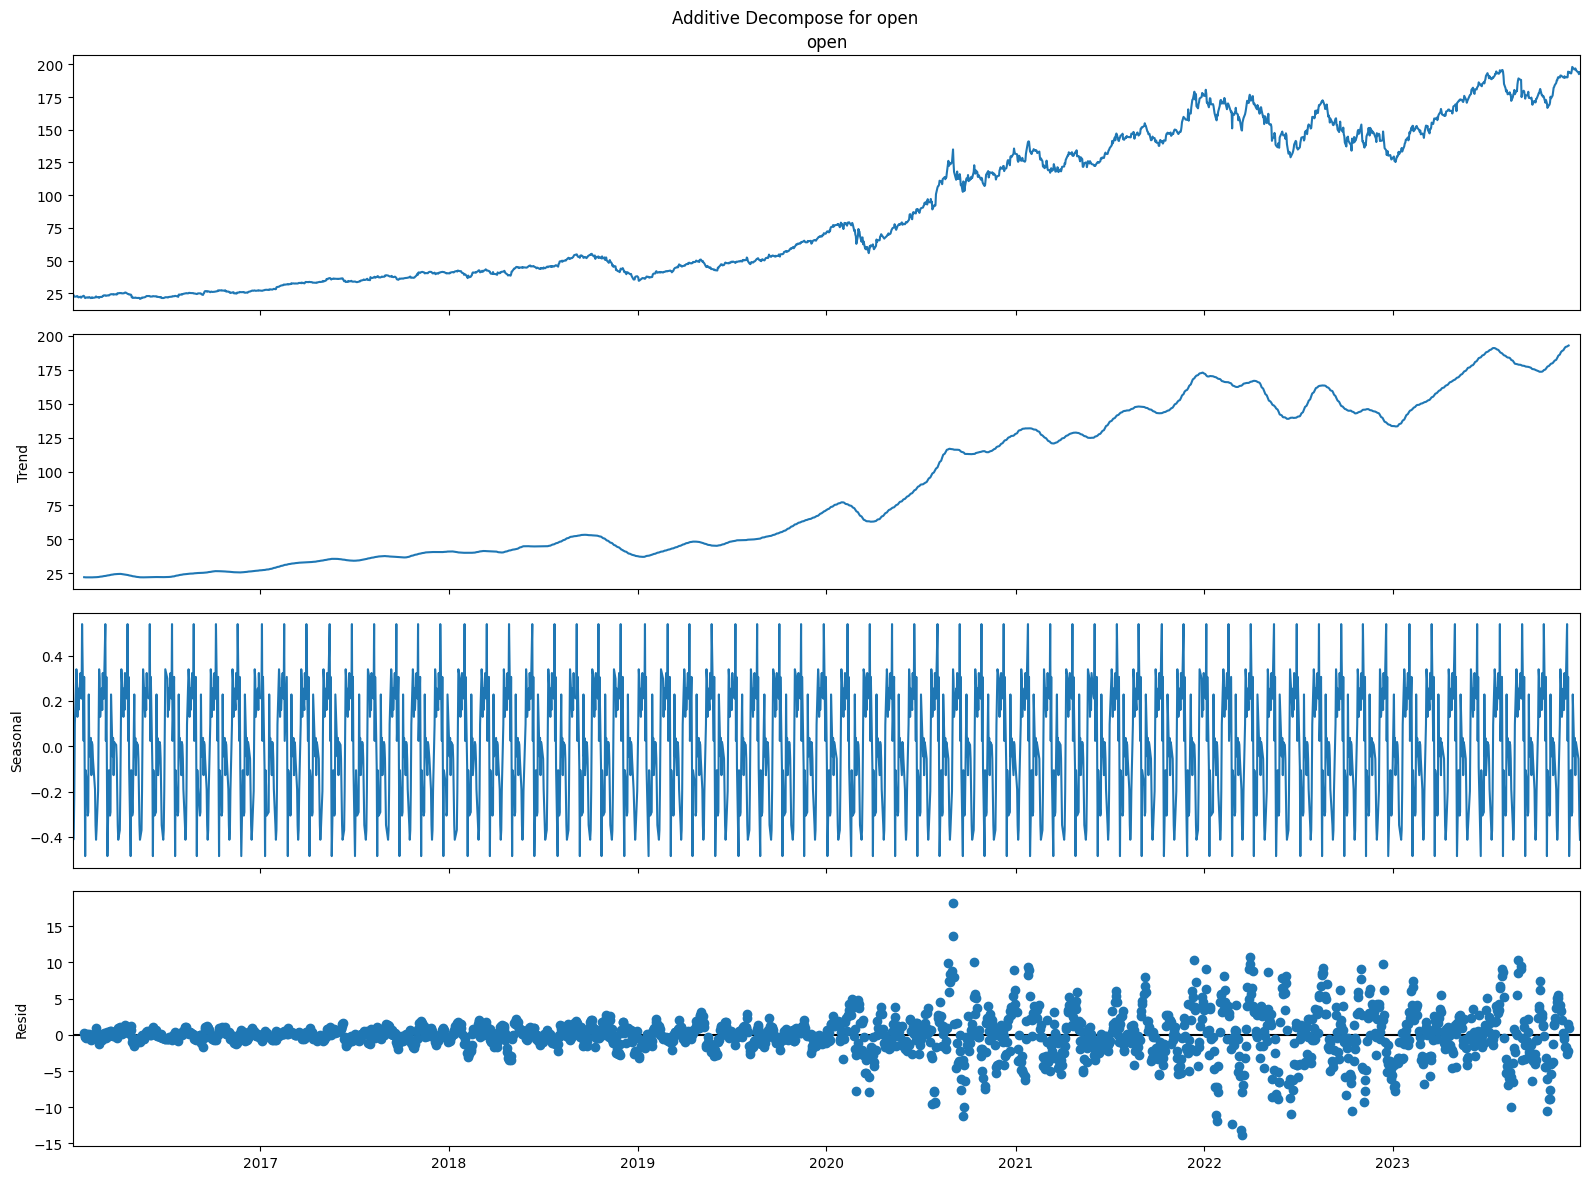

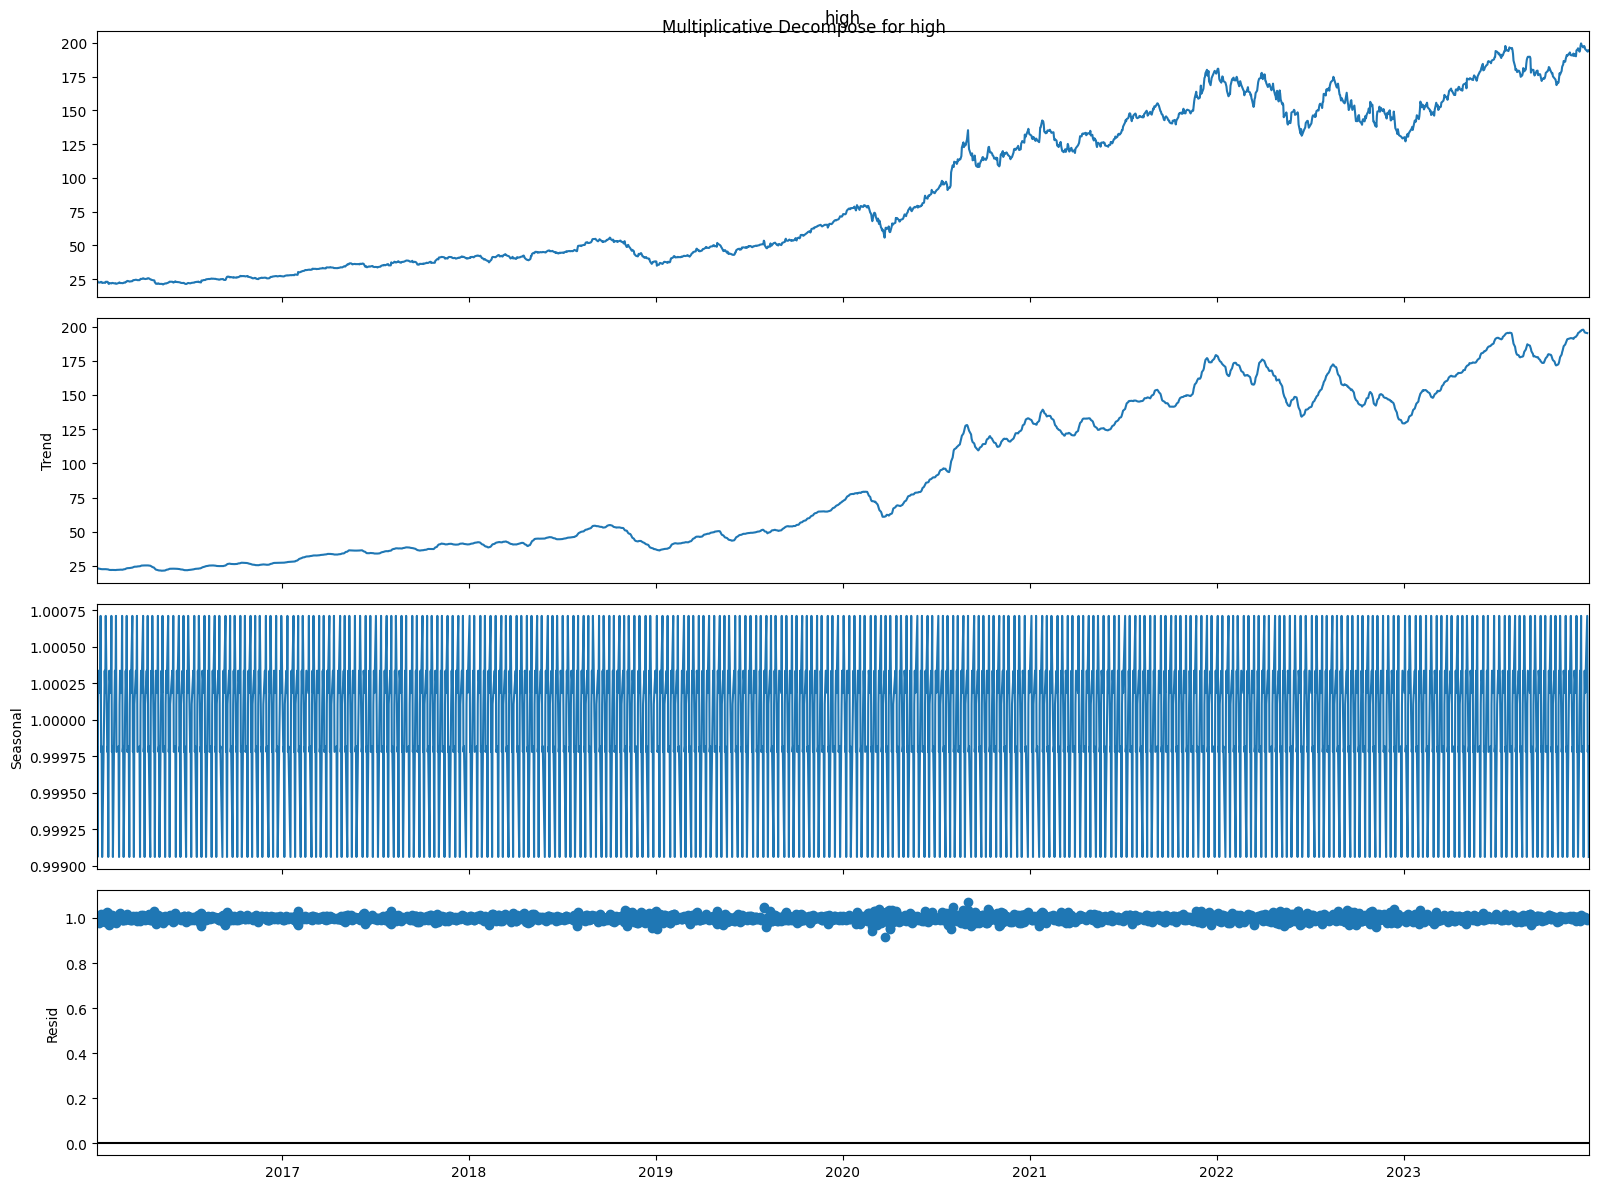

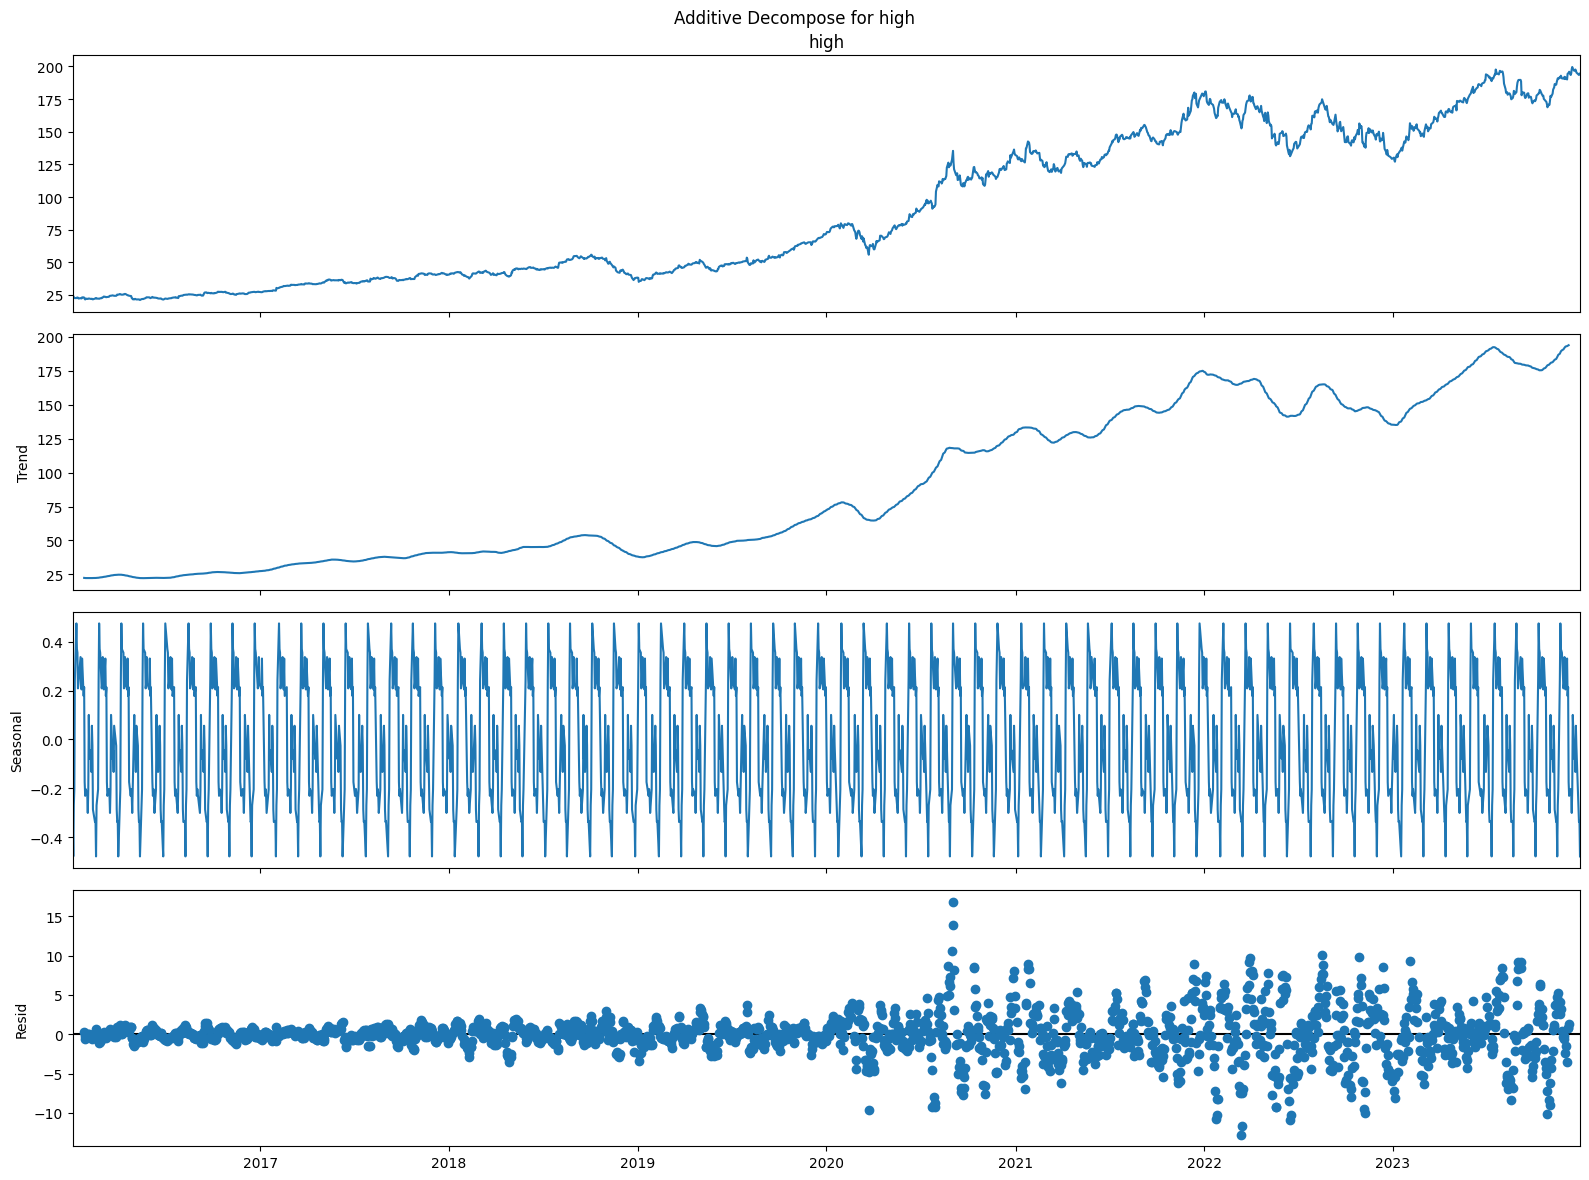

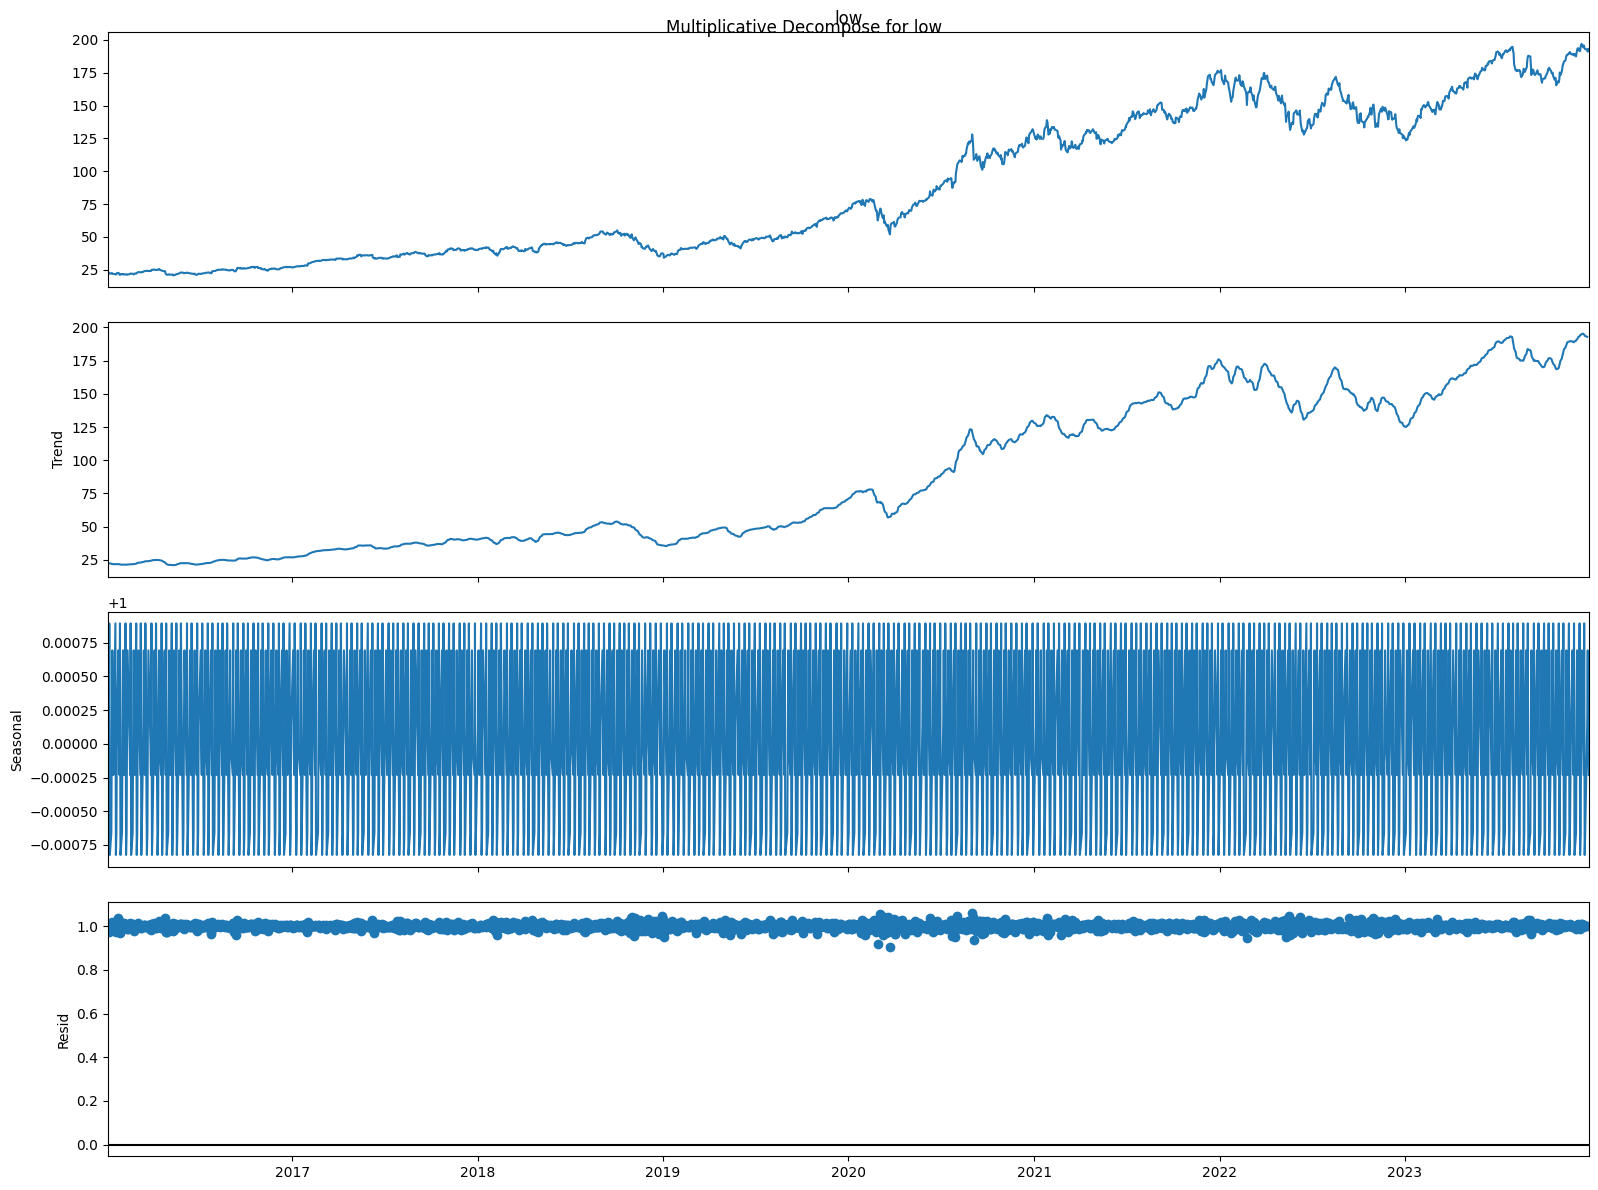

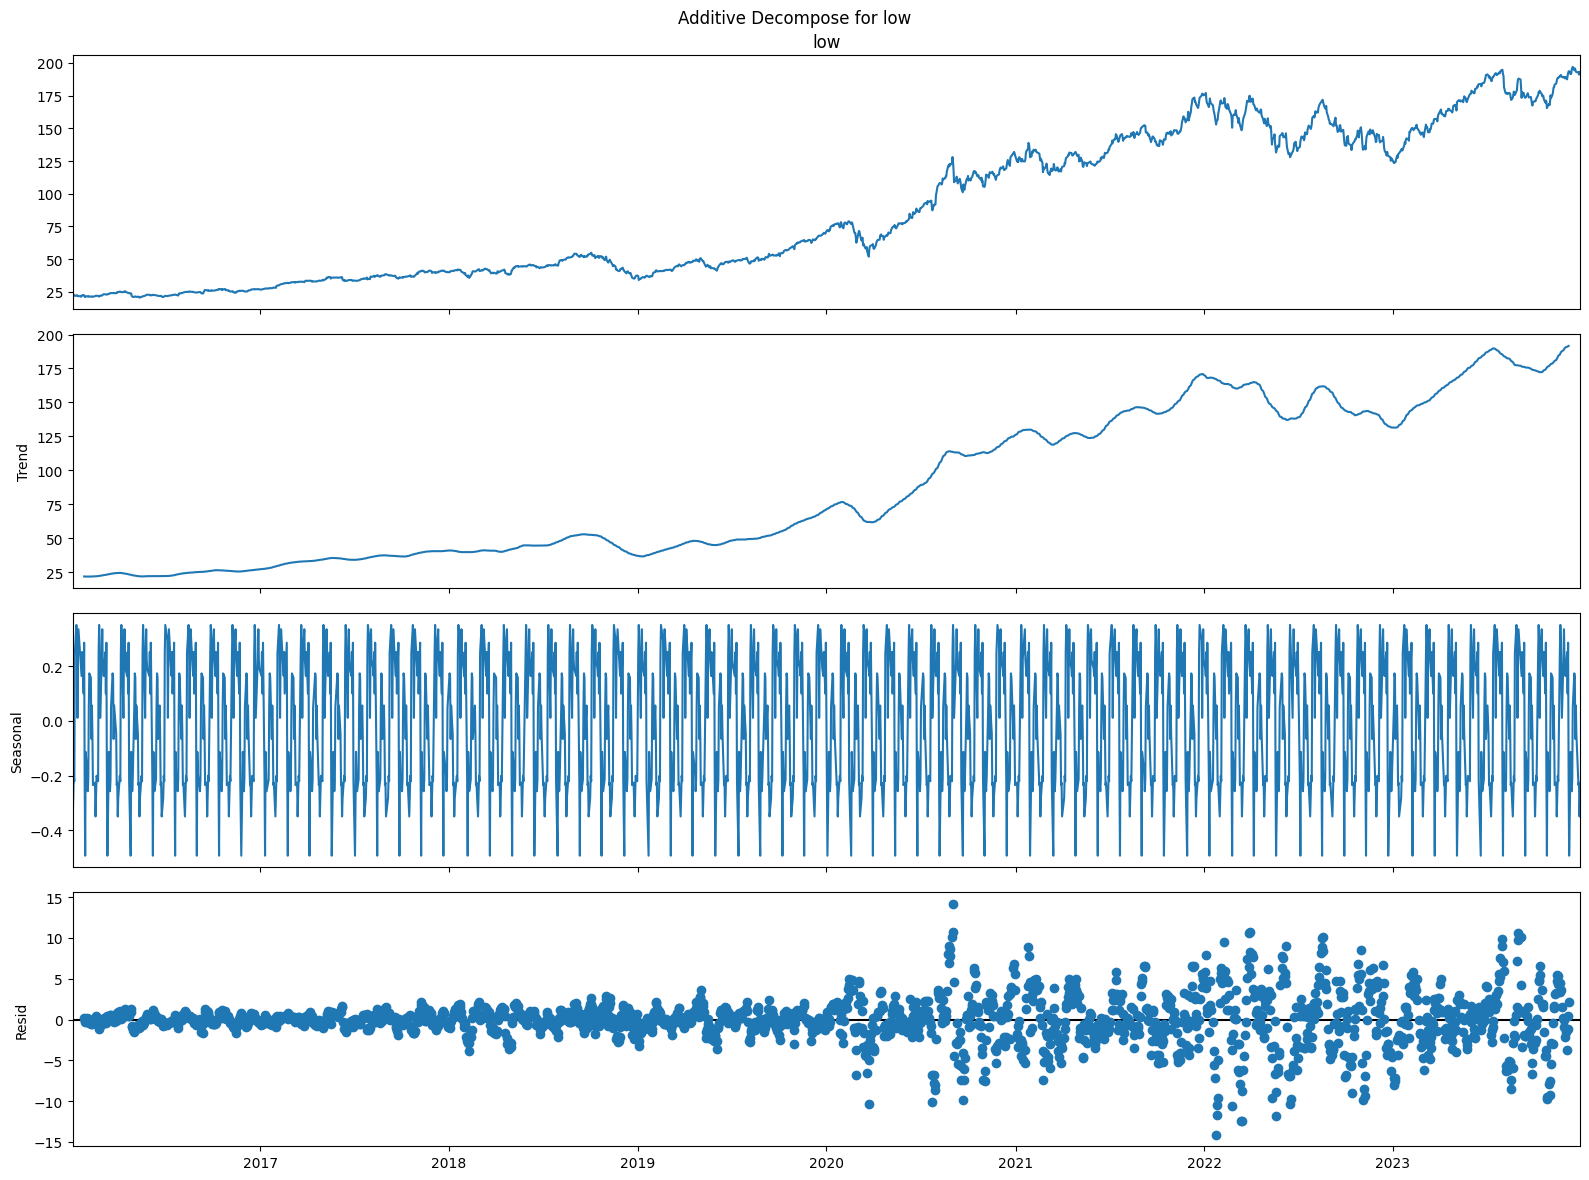

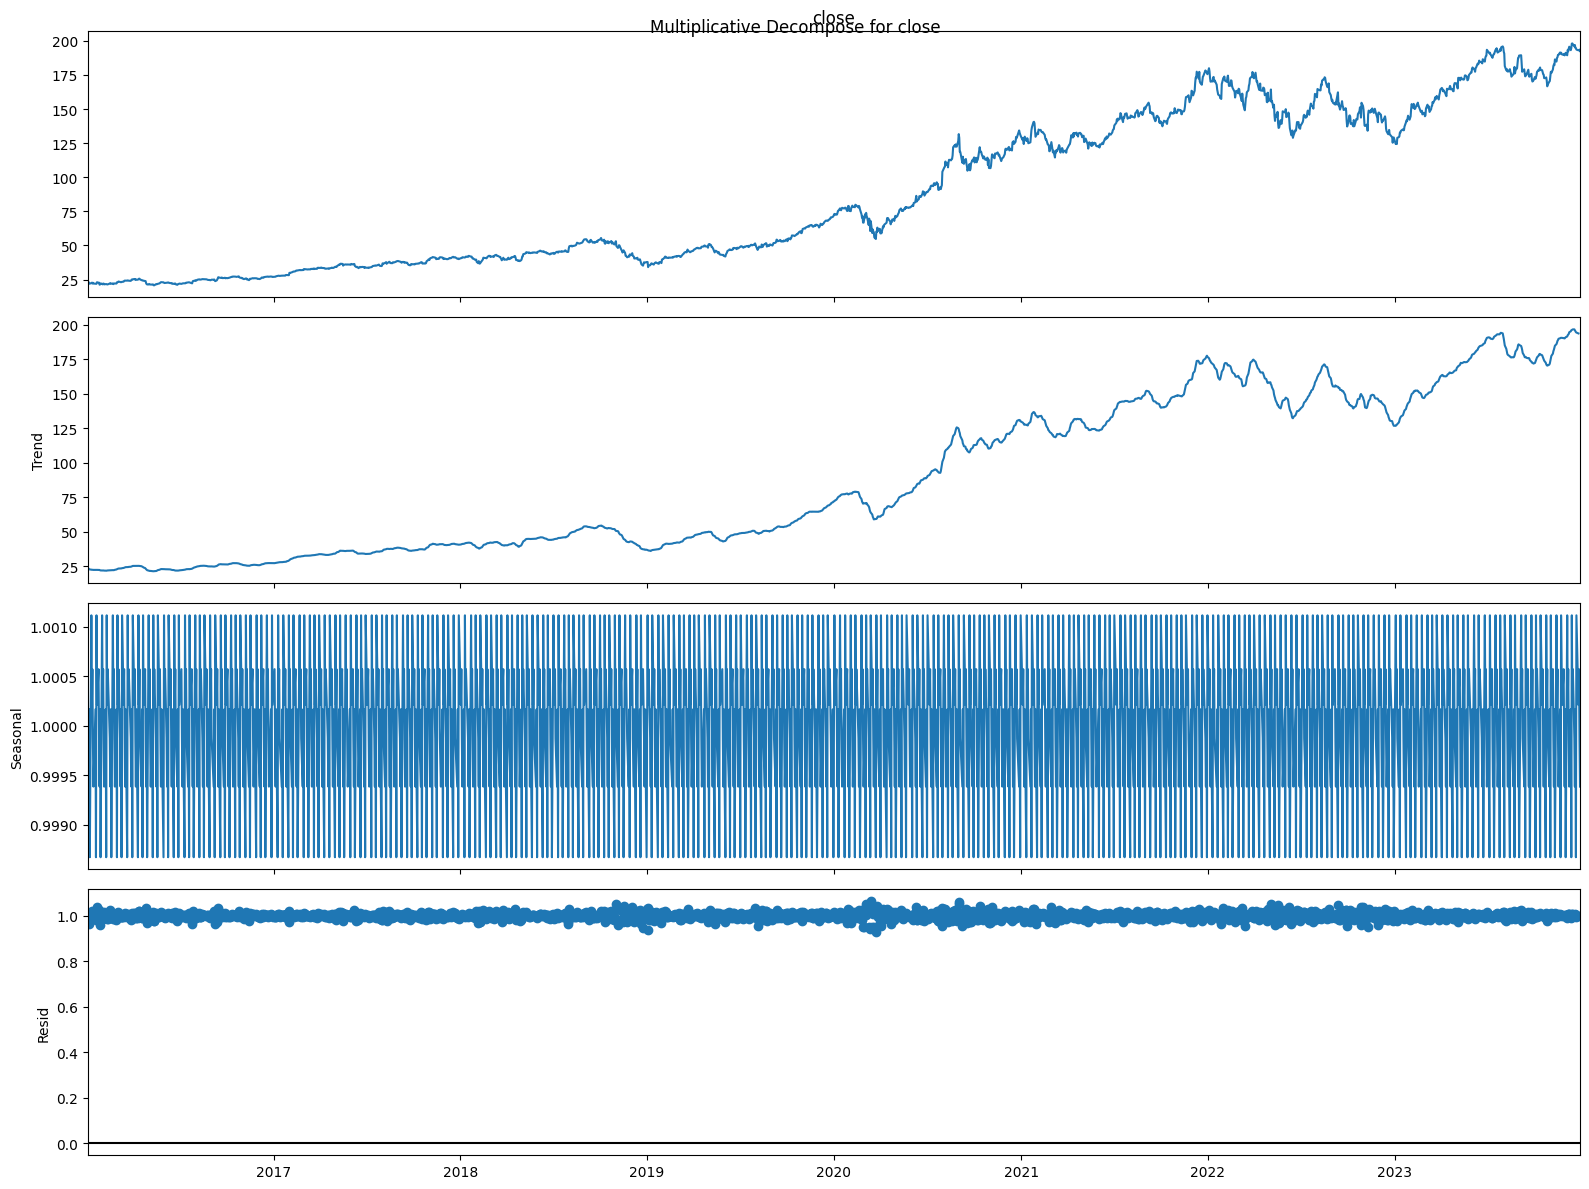

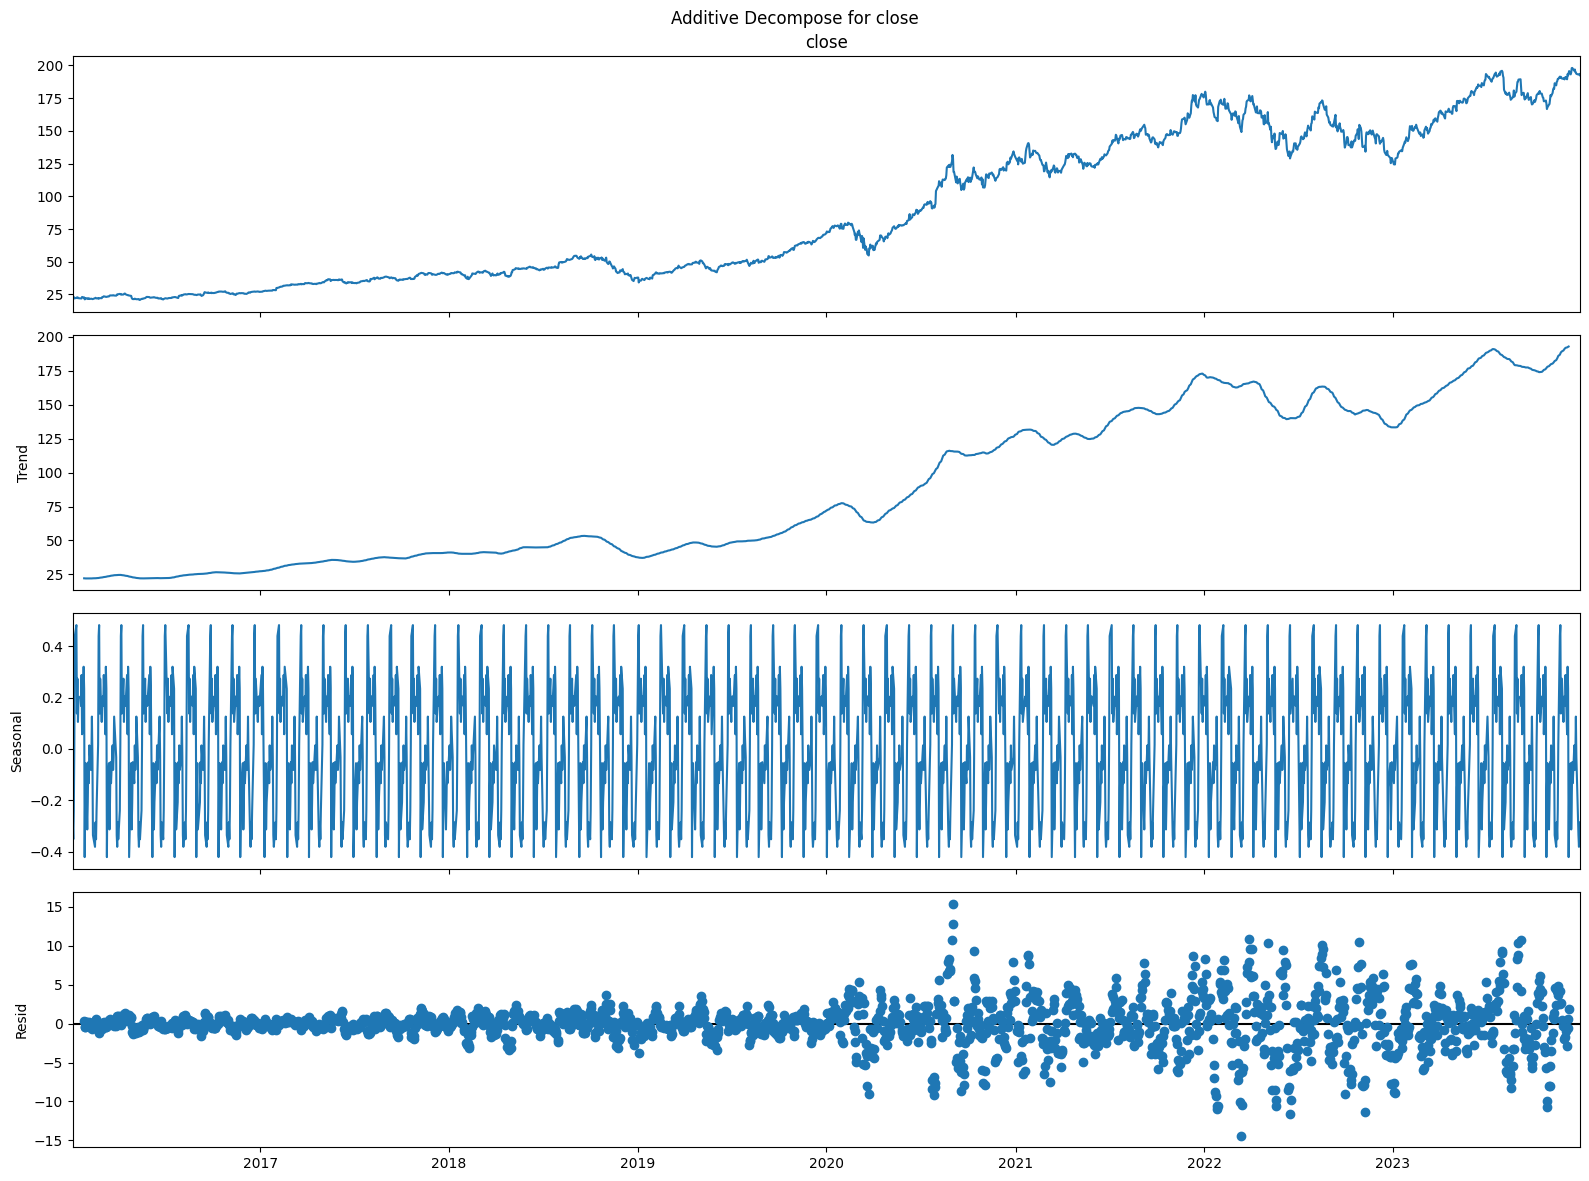

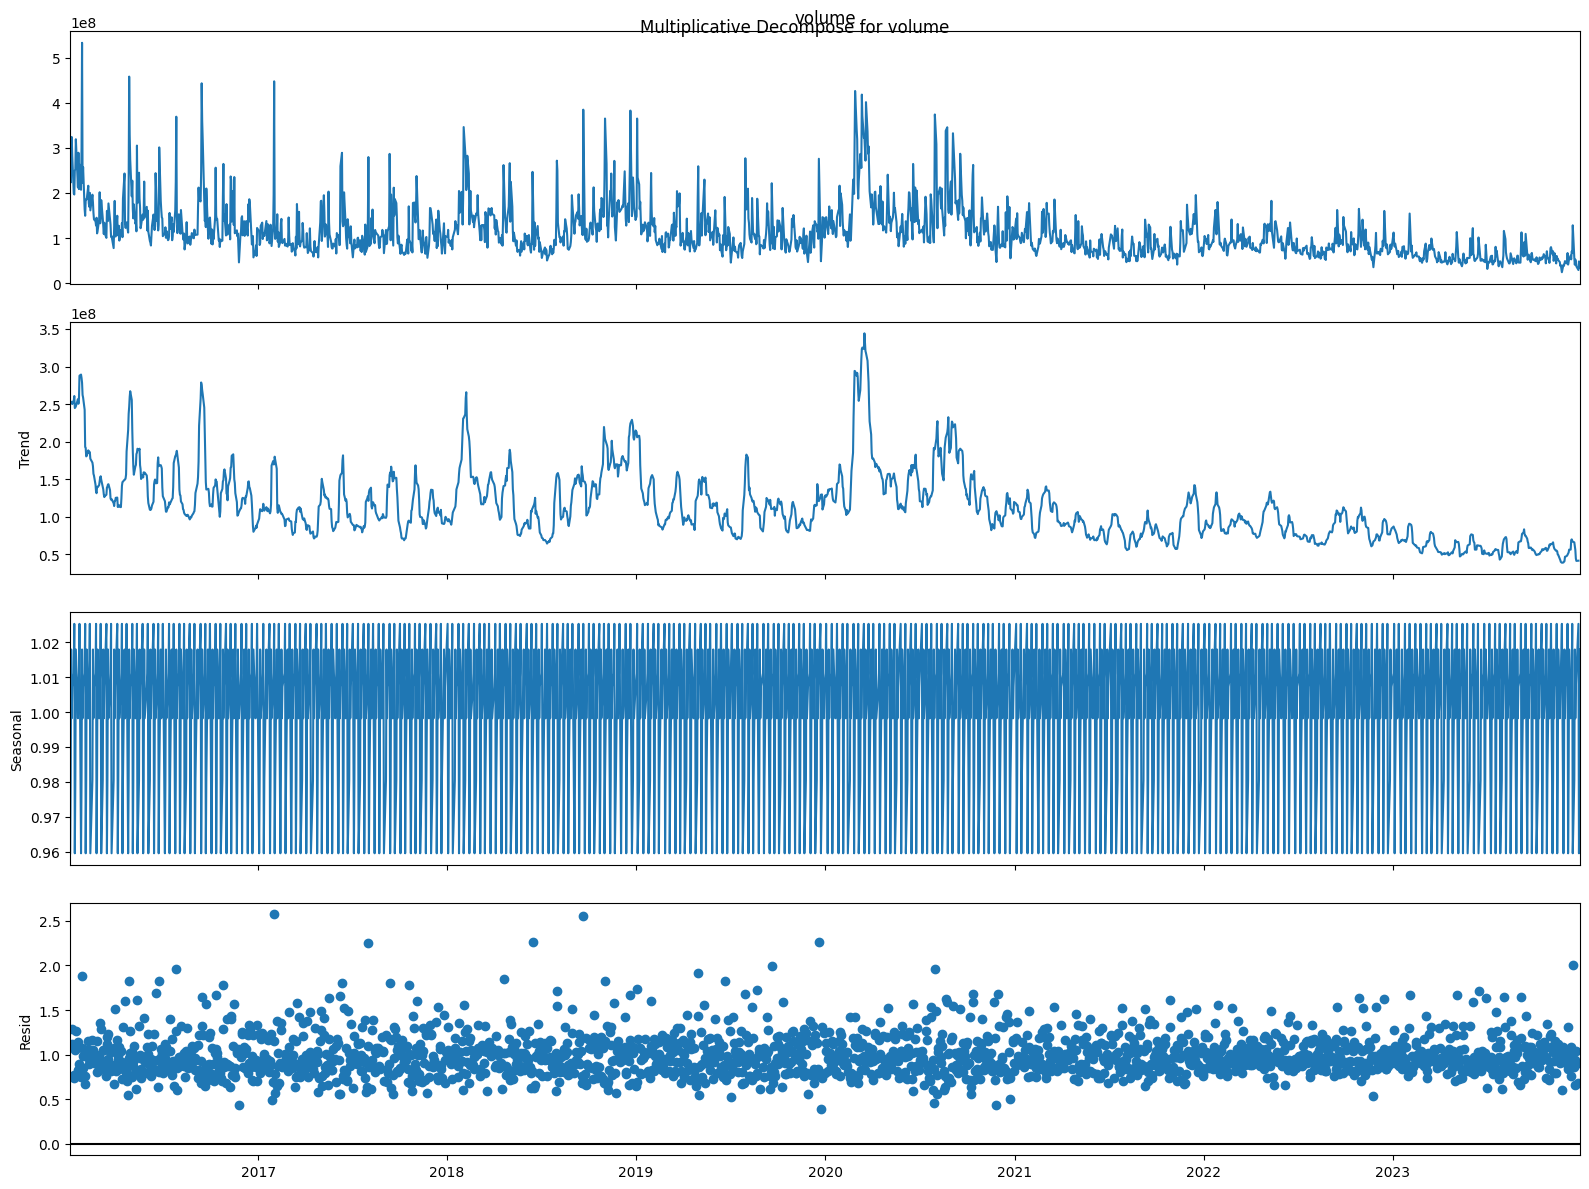

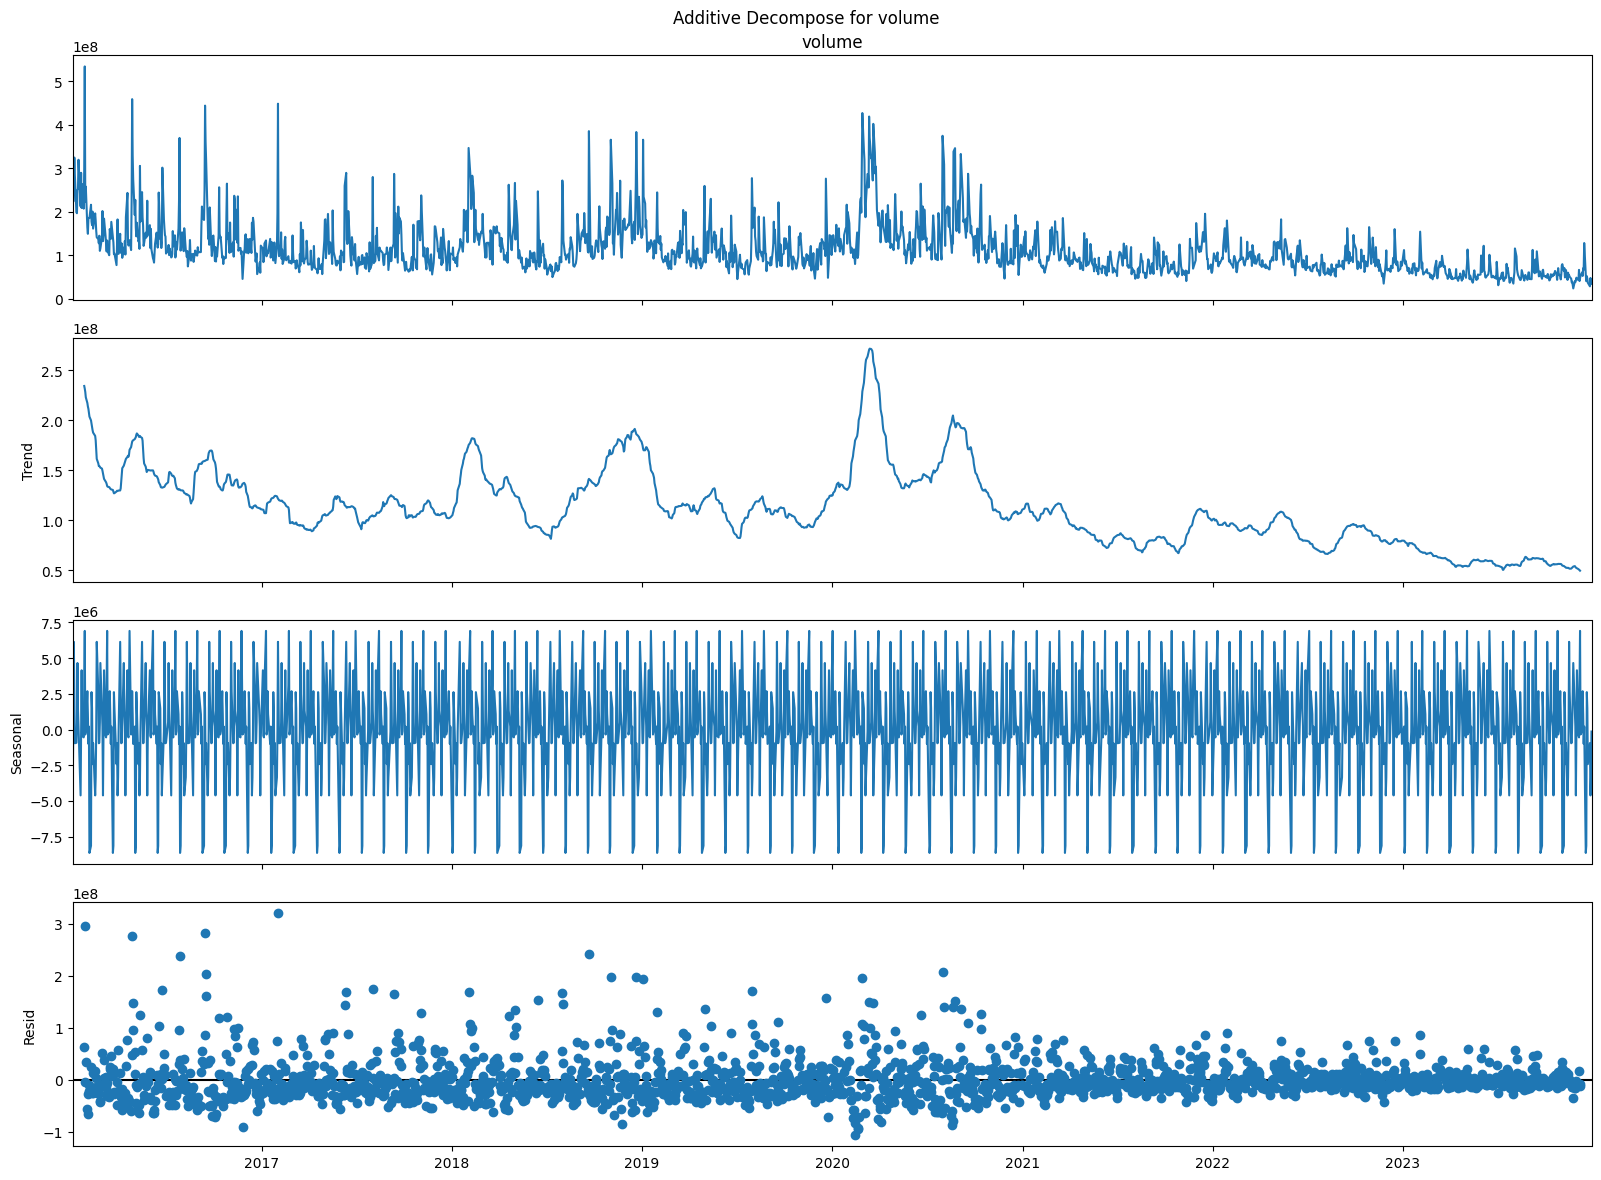

In [32]:
def plotDecompose(values,column):
    multiplicativeDecompose = seasonal_decompose(values,model='multiplicative',period=7)
    additiveDecompose = seasonal_decompose(values,model='additive',period=30)

    plt.rcParams.update({'figure.figsize': (16,12)})
    multiplicativeDecompose.plot().suptitle(f'Multiplicative Decompose for {column}')
    additiveDecompose.plot().suptitle(f'Additive Decompose for {column}')

    plt.tight_layout()

for _ in df.columns:
    plotDecompose(df[_],_)

df.reset_index(inplace=True)

Looking at the decomposition graphs we can say that the data is multiplicative as in residuals there is little to no pattern left

## EDA

In [8]:
subFig = make_subplots(rows=2, cols=1)

subFig.add_trace(go.Scatter(x=df["date"], y=df["open"], 
              mode='lines',name="Open Price"),row=1,col=1)

subFig.add_trace(go.Scatter(x=df["date"], y=df["close"], 
              mode='lines',name="Close Price"),row=2,col=1)

subFig.update_layout(height=600, width=1200, title_text=f"Open & Close Price for {stockTicker}", showlegend=True)
subFig.show()

In [9]:
subFig = make_subplots(rows=2, cols=1)

subFig.add_trace(go.Scatter(x=df["date"], y=df["high"], 
              mode='lines',name="High Price"),row=1,col=1)

subFig.add_trace(go.Scatter(x=df["date"], y=df["low"], 
              mode='lines',name="Low Price"),row=2,col=1)

subFig.update_layout(height=600, width=1200, title_text=f"High & Low Price for {stockTicker}", showlegend=True)
subFig.show()

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df["date"], y=df["volume"],name='Volume Traded',line=dict(color='black', width=1)))
fig.update_layout(height=600, width=1200, title_text=f"Volume Traded {stockTicker}", showlegend=True)

In [11]:
monthOrder = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']

In [12]:
monthwise = df.groupby(df['date'].dt.strftime('%B')).agg(
    meanOpen = ('open','mean'),
    meanClose = ('close','mean'),
    minOpen = ('open','min'),
    minClose = ('close','min'),
    maxOpen = ('open','max'),
    maxClose = ('close','max'))

monthwise.index.names = ['month']
monthwise = monthwise.reindex(monthOrder)
monthwise.reset_index(inplace=True)
monthwise

month    meanOpen   meanClose    minOpen   minClose     maxOpen  \
0     January   79.184040   79.262452  21.346438  21.262230  180.566891   
1    February   81.721619   81.842390  21.311238  21.441683  174.282979   
2       March   81.646400   81.797275  22.345565  23.004604  176.757918   
3       April   83.118007   83.161605  21.508035  21.450827  175.718430   
4         May   83.001708   83.068389  20.720384  20.798656  176.857850   
5        June   85.118355   85.268918  21.388043  21.190044  191.119801   
6        July   90.498579   90.742244  21.779427  21.869217  195.537995   
7      August   96.058057   96.109315  24.037948  24.054066  195.717515   
8   September   95.543641   95.218862  23.760770  23.871881  189.240698   
9     October   92.906681   93.143886  26.089404  26.045424  181.181296   
10   November   96.706884   96.852532  24.794803  24.594713  191.490005   
11   December  101.369892  101.366932  25.399726  25.385765  198.020004   

      maxClose  
0   179.953888  
1   174.510666  
2   177.163773  
3   176.649002  
4   176.827942  
5   193.453568  
6   195.926956  
7   195.089188  
8   189.450409  
9   180.472244  
10  191.449997  
11  198.110001

In [13]:
subFig = make_subplots(rows=3, cols=1)

subFig.add_trace(go.Bar(x=monthwise['month'], y=monthwise["meanOpen"],
              name="Mean Opening Price"),row=1,col=1)

subFig.add_trace(go.Bar(x=monthwise['month'], y=monthwise["meanClose"], 
              name="Mean Closing Price"),row=1,col=1)

subFig.add_trace(go.Bar(x=monthwise['month'], y=monthwise["maxClose"], 
              name="Max Closing Price"),row=2,col=1)

subFig.add_trace(go.Bar(x=monthwise['month'], y=monthwise["maxOpen"], 
              name="Max Opening Price"),row=2,col=1)

subFig.add_trace(go.Bar(x=monthwise['month'], y=monthwise["minOpen"], 
              name="Min Opening Price"),row=3,col=1)

subFig.add_trace(go.Bar(x=monthwise['month'], y=monthwise["minClose"], 
              name="Min Closing Price"),row=3,col=1)

subFig.update_layout(height=1000, width=1200, title_text=f"Mean, Max & Min Closing and Opening for {stockTicker} Monthwise", showlegend=True)
subFig.show()

### Stationarity Test for Data

#### Checking for stationarity using plot

In [14]:
rollingWindow = 30
subFig = make_subplots(rows=3, cols=1)

subFig.add_trace(go.Scatter(x=df["date"], y=df["open"],name='Open Price'),row=1,col=1)
subFig.add_trace(go.Scatter(x=df["date"], y=df["open"].rolling(rollingWindow).mean(),name='Opening Rolling Mean'),row=1,col=1)
subFig.add_trace(go.Scatter(x=df["date"], y=df["open"].rolling(rollingWindow).std(),name='Opening Standard Deviation'),row=1,col=1)

subFig.add_trace(go.Scatter(x=df["date"], y=df["close"],name='Close Price'),row=2,col=1)
subFig.add_trace(go.Scatter(x=df["date"], y=df["close"].rolling(rollingWindow).mean(),name='Closing Rolling Mean'),row=2,col=1)
subFig.add_trace(go.Scatter(x=df["date"], y=df["close"].rolling(rollingWindow).std(),name='Closing Standard Deviation'),row=2,col=1)

subFig.add_trace(go.Scatter(x=df["date"], y=df["volume"],name='Volume Traded'),row=3,col=1)
subFig.add_trace(go.Scatter(x=df["date"], y=df["volume"].rolling(rollingWindow).mean(),name='Volume Traded Rolling Mean'),row=3,col=1)
subFig.add_trace(go.Scatter(x=df["date"], y=df["volume"].rolling(rollingWindow).std(),name='Volume Traded Deviation'),row=3,col=1)


subFig.update_layout(height=800, width=1200, title_text=f"Open Price for {stockTicker} with Rolling Mean & Standard Deviation", showlegend=True)
subFig.show()

Checking the plot was inconclusive so we will perform unit test

#### ADF Fuller Test

Null Hypothesis: The time series has a unit root and the data is not stationary
Significance Value = 0.05

In [15]:
def visualizeAdfFullerResults(df,series, title):
    result = adfuller(series)
    significanceLevel = 0.05
    adfStat = result[0]
    pVal = result[1]
    critVal1 = result[4]['1%']
    critVal5 = result[4]['5%']
    critVal10 = result[4]['10%']
    stationary = pVal < significanceLevel

    if stationary:
        linecolor = 'green' if adfStat < critVal1 else 'orange' if adfStat < critVal5 else 'red'
        stationarity_status = 'Stationary'
    else:
        linecolor = 'purple'
        stationarity_status = 'Not Stationary'

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['date'], y=series, mode='lines', line=dict(color=linecolor)))
    fig.update_layout(yaxis_title=title)

    title = f'{title} - {stationarity_status} (ADF Statistic {adfStat:0.3f}, p-value: {pVal:0.3f})'
    return fig, title


fig = make_subplots(rows=5, cols=1)


figOpen, title_open = visualizeAdfFullerResults(df,df['open'].values, 'Open Price')
fig.add_traces(figOpen.data, rows=1, cols=1)


figClose, title_close = visualizeAdfFullerResults(df,df['close'].values, 'Close Price')
fig.add_traces(figClose.data, rows=2, cols=1)

figHigh, title_high = visualizeAdfFullerResults(df,df['high'].values, 'High Price')
fig.add_traces(figHigh.data, rows=3, cols=1)

figLow, title_low = visualizeAdfFullerResults(df,df['low'].values, 'Low Price')
fig.add_traces(figLow.data, rows=4, cols=1)

figVolume, titleVolume = visualizeAdfFullerResults(df,df['volume'].values, 'Volume Traded')
fig.add_traces(figVolume.data, rows=5, cols=1)

fig.update_layout(
    height=1000, 
    width=1200, 
    title_text="ADF Test Results",
    annotations=[
        dict(text=title_open, x=0.5, xref="paper", y=1.03, yref="paper", showarrow=False, font=dict(size=14)),
        dict(text=title_close, x=0.5, xref="paper", y=0.82, yref="paper", showarrow=False, font=dict(size=14)),
        dict(text=title_high, x=0.5, xref="paper", y=0.59, yref="paper", showarrow=False, font=dict(size=14)),
        dict(text=title_low, x=0.5, xref="paper", y=0.38, yref="paper", showarrow=False, font=dict(size=14)),
        dict(text=titleVolume, x=0.5, xref="paper", y=0.16, yref="paper", showarrow=False, font=dict(size=14))
    ],
    showlegend=False
)

fig.show()

We can see that the open, close, high, and low columns are not stationary as the p-value is > 0.05 so we fail to reject the null-hypothesis. But, in the case of Volume column p-value = 0.000 which is < 0.05 thus we can reject the null hypothesis